In [14]:
import torch
from torch.nn import Module
from torch import Tensor
from mytransformers import TransformerEncoderDecoderModel, ModelTrainer
from mytransformers import layers
import torch.nn as nn
device = torch.device('cuda')

In [15]:
from mytransformers import AttentionKVCacheCore

In [16]:
VOCAB_SIZE = 5000
MAX_LEN = 128

PAD_TOKEN_ID = 0
UNK_TOKEN_ID = 1
BOS_TOKEN_ID = 2
EOS_TOKEN_ID = 3

In [17]:
from datasets import load_dataset

print("Download TinyStories...")
dataset = load_dataset("roneneldan/TinyStories",
                       split=f"train[:{VOCAB_SIZE}]")

with open("tinystories.txt", "w") as f:
    for example in dataset:
        text = example["text"].strip().lower()
        f.write(text + "\n")

print("Save in tinystories.txt")

Download TinyStories...
Save in tinystories.txt


In [18]:
import sentencepiece as spm

spm.SentencePieceTrainer.train(
    input='tinystories.txt',
    model_prefix='tiny_tokenizer',
    vocab_size=VOCAB_SIZE,
    model_type='bpe',
    character_coverage=1.0,
    pad_id=PAD_TOKEN_ID,
    unk_id=UNK_TOKEN_ID,
    bos_id=BOS_TOKEN_ID,
    eos_id=EOS_TOKEN_ID,
    minloglevel=2 
)

print("Токенизатор обучен: tiny_tokenizer.model")

sp = spm.SentencePieceProcessor()
sp.load("tiny_tokenizer.model")

Токенизатор обучен: tiny_tokenizer.model


True

In [19]:
import torch
from torch.utils.data import Dataset, DataLoader

class StoryDataset(Dataset):
    def __init__(self, texts, tokenizer, max_len=64):
        self.texts = [t.strip().lower() for t in texts]
        self.tokenizer = tokenizer
        self.max_len = max_len
        self.pad_id = 0
        self.bos_id = 2
        self.eos_id = 3

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        ids = self.tokenizer.encode(text, out_type=int)

        if len(ids) > self.max_len - 2:
            ids = ids[:self.max_len - 2]

        input_ids = [self.bos_id] + ids + [self.eos_id]
        target_ids = [self.bos_id] + ids + [self.eos_id]

        padding = [self.pad_id] * (self.max_len - len(input_ids))
        input_ids += padding
        target_ids += padding

        return {
            "source": torch.tensor(input_ids),
            "target": torch.tensor(target_ids)
        }

texts = [ex["text"] for ex in dataset]
story_dataset = StoryDataset(texts, sp, max_len=MAX_LEN + 1)

In [20]:
NUM_LAYERS = 10
HIDDEN_STATE = 256

# Attention
NUM_QUERY_HEADS = 16
NUM_KV_HEADS = 4
QK_DIM = 256
V_DIM = 256

# FFN
FFN_DIM = 512

# MoE

NUM_EXPERTS = 8
K=2

In [21]:

positional_encoding = layers.PositionalEncoding(hidden_state=HIDDEN_STATE, max_len=MAX_LEN)

self_attn = layers.SelfAttention(
    hidden_state=HIDDEN_STATE,
    num_query_heads=NUM_QUERY_HEADS,
    num_kv_heads=NUM_KV_HEADS,
    qk_dim=QK_DIM,
    v_dim=V_DIM
)

cross_attn = layers.CrossAttention(
    hidden_state=HIDDEN_STATE,
    num_query_heads=NUM_QUERY_HEADS,
    num_kv_heads=NUM_KV_HEADS,
    qk_dim=QK_DIM,
    v_dim=V_DIM
)

expert = layers.FeedForward(
    hidden_state=HIDDEN_STATE,
    ffn_dim=FFN_DIM
)

encoder_layer = layers.TransformerEncoderLayer(
    hidden_state=HIDDEN_STATE,
    attn_model=self_attn,
    ffn_model=expert
)

decoder_layer = layers.TransformerDecoderLayer(
    hidden_state=HIDDEN_STATE,
    self_attn_model=self_attn,
    ffn_model=expert,
    encoder_output=True,
    cross_attn_model=cross_attn
)
model = TransformerEncoderDecoderModel(
    vocab_size=VOCAB_SIZE,
    pad_token_id=PAD_TOKEN_ID,
    num_layers=NUM_LAYERS,
    hidden_state=HIDDEN_STATE,
    positional_encoding_model=positional_encoding,
    encoder_layer=encoder_layer,
    decoder_layer=decoder_layer
    
)

In [22]:
optimizer = torch.optim.Adam(model.parameters(), lr=3e-4)
criterion = torch.nn.CrossEntropyLoss(ignore_index=0)

In [23]:
trainer = ModelTrainer(
    num_epochs=10,
    batch_size=16,
    pad_token_id=0 
)

test_losses = trainer.train(
    data=story_dataset,
    model=model,
    optimizer=optimizer,
    criterion=criterion
)

# График
trainer.print_loss_history(path_save="loss_plot")

100%|██████████| 3130/3130 [13:34<00:00,  3.84batch/s, Epoch Loss=5.8236]       


График сохранён: loss_plot.png


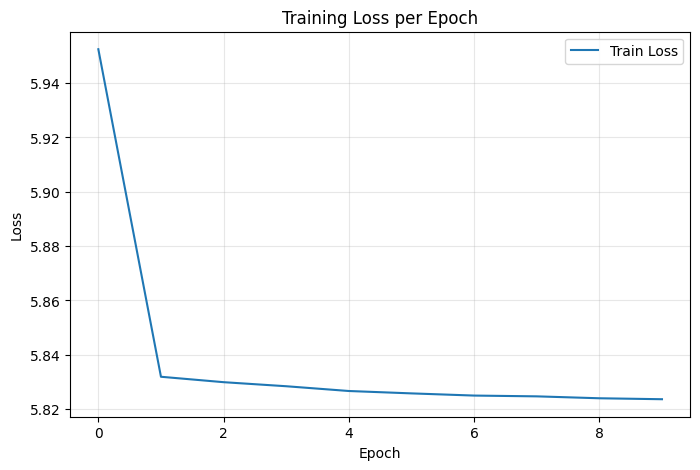

In [26]:
trainer.print_loss_history(path_save="loss_plot")

In [24]:
def generate(model: TransformerEncoderDecoderModel, tokenizer, prompt, max_len=100):
    model.eval()
    tokens = tokenizer.encode(prompt.lower(), out_type=int)
    tokens = [2] + tokens  # <bos>
    model.generate(tokens, tokens, 3, max_len)
        

    return tokens

# Пример
prompt = ""
gen = generate(model, sp, prompt, max_len=30)
print("Сгенерировано:", gen)

Сгенерировано: [2, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954]


In [25]:
AttentionKVCacheCore.call_kv_cache_method(model, "disable_kv_cache") 
def generate(model, tokenizer, prompt, max_len=100, device='cuda'):
    model.eval()
    tokens = tokenizer.encode(prompt.lower(), out_type=int)
    tokens = [2] + tokens  # <bos>

    src = torch.tensor([tokens]).to(device)
    for _ in range(len(tokens), max_len):
        tgt = torch.tensor([tokens]).to(device)

        with torch.no_grad():
            logits = model(src, tgt)
            next_token_logits = logits[0, -1, :]  # последний токен
            next_token = torch.argmax(next_token_logits, dim=-1).item()

        if next_token == 3:  # <eos>
            break
        tokens.append(next_token)

    return tokens

# Пример
prompt = ""
gen = generate(model, sp, prompt, max_len=30)
print("Сгенерировано:", gen)

Сгенерировано: [2, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954, 4954]
